# Importing code from the previous notebook

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# importing our latest Value class

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children)     # previous node
        self._op = _op                  # the operation that produced this node
        self._backward = lambda: None   # to do the little piece of chain rule at each local node, backwards
                                        # by default _backward is None, as there is nothing to do at a leaf node

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # local derivative (= 1.0) * out's grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # local derivative (= switching the data of leaf nodes) * out's grad
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # local derivative of tanh (1 - tanh(x)**2) * out's grad
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # our topological sort function
        def topological_sort(node):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(node)
            return topo

        # base case
        self.grad = 1.0

        # and then traverse backwards, calling _backward() on the way
        for node in reversed(topological_sort(self)):
            node._backward()

In [3]:
# import visualization functions to show grads

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


# backprop bug when one node is used multiple times

In [4]:
# let's take a look at cases when our backprop fails with the current implementation

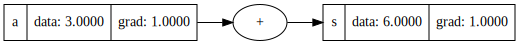

In [5]:
# when op is performed on the same node (example #1)
a = Value(3.0, label='a')
s = a + a;  s.label='s'
s.backward()
draw_dot(s)

In [6]:
# think about it! we have the equn as: 
# s = a + a
# => s = 2a
# now using calculus, differentiating both sides
# ds/da = d/da (2a)
# => ds/da = 2 * (da/da)
# => ds/da = 2 * 1.0 = 2.0
# but our backward() calculates the grad as 1.0 !!

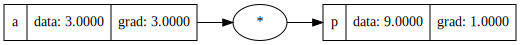

In [7]:
# when op is performed on the same node (example #2)
p = a * a;  p.label='p'
p.backward()
draw_dot(p)

In [8]:
# similarly, think about this too! we have the equn as: 
# p = a * a
# => p = a^2
# now using calculus, differentiating both sides
# dp/da = d/da (a^2)
# => dp/da = 2a
# => dp/da = 2 * 3.0 = 6.0
# but our backward() calculates the grad as 3.0 !!

In [9]:
# so what's hapenning here? where is it going wrong?

# intuitively, issue is in _backward() function.
# let's take a look at _backward() of (+):
# def _backward():
#     self.grad = 1.0 * out.grad
#     other.grad = 1.0 * out.grad

# here when the same nodes are called for an operation (a + a = b, where a and a are same nodes),
# the `self.grad` and `other.grad` are pointing to the same node -> a, 
# as a result, the values are getting over written, instead of getting accumulated

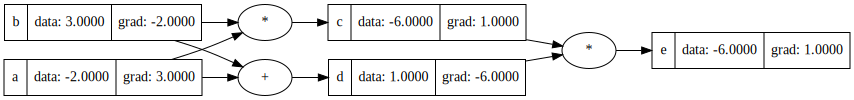

In [10]:
# there is another way to visualize the same issue with different nodes (example #3):
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b;  c.label='c'
d = a + b;  d.label='d'
e = c * d;  e.label='e'

e.backward()
draw_dot(e)

In [11]:
# similar issue pops up, when a variable get's used more than once!

# if you call the cell above multiple times, 
# you will see sometimes we end up with grads of (a,b) as (3,-2), and sometimes (-6, -6)
# this is based on which _backward() get's called first... c's grads are deposited as (3,-2), where as d's grads are deposited as (-6, -6)

# so, we see the grads get's replaced, insted of accumulated 

In [12]:
# we can do a quick calculation to see the actual grads theoritically:
# e = c * d = (a * b) * (a + b)
# => e = ab(a + b)
# => e = aab + abb

# differentiating both sides w.r.t a:
# de/da = d/da (aab + abb)
# de/da = b*2a + b^2 = 2ab + b^2 = 2*(-2)*3 + 3*3 = -12 + 9 = -3

# differentiating both sides w.r.t b:
# de/db = d/db (aab + abb)
# de/db = a^2 + a*2b = a^2 + 2ab = (-2)^2 + 2*(-2)*3 = 4 - 12 = -8

# so we see, the answer is neither (3,-2) nor (-6, -6), but (-3, -8), which is an accumulation of both the local grads!

In [13]:
# let's fix it! (reference: above explaination + wiki: https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case)

# we simply += the grads in all the _backward() functions.
# and since the default value of the grad = 0.0, for single node case, it will still work, 
# and _backward() is now generalized! which in tern fixes our bug too!

In [14]:
# updating our Value class with bugfix

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children)     # previous node
        self._op = _op                  # the operation that produced this node
        self._backward = lambda: None   # to do the little piece of chain rule at each local node, backwards
                                        # by default _backward is None, as there is nothing to do at a leaf node

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # local derivative (= 1.0) * out's grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # local derivative (= switching the data of leaf nodes) * out's grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # local derivative of tanh (1 - tanh(x)**2) * out's grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # our topological sort function
        def topological_sort(node):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(node)
            return topo

        # base case
        self.grad = 1.0

        # and then traverse backwards, calling _backward() on the way
        for node in reversed(topological_sort(self)):
            node._backward()

In [15]:
# let's check back our example corner cases, and see if the issue is fixed or not

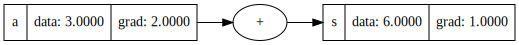

In [16]:
# example #1
a = Value(3.0, label='a')
s = a + a;  s.label='s'
s.backward()
draw_dot(s)

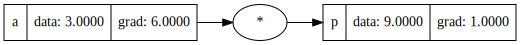

In [17]:
# example #2
a = Value(3.0, label='a')
p = a * a;  p.label='p'
p.backward()
draw_dot(p)

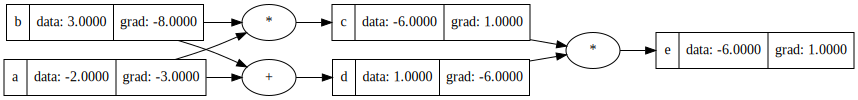

In [18]:
# example #3
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b;  c.label='c'
d = a + b;  d.label='d'
e = c * d;  e.label='e'

e.backward()
draw_dot(e)

# Update micrograd with other operations and reverse operations

In [26]:
# read through the comments, as I am skipping in-depth explainations here

In [27]:
# updating our Value class with other ops and reverse ops

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.label = label  # optional, Value variable/node name
        self.data = data
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children)     # previous node
        self._op = _op                  # the operation that produced this node
        self._backward = lambda: None   # to do the little piece of chain rule at each local node, backwards
                                        # by default _backward is None, as there is nothing to do at a leaf node

    def __repr__(self):
        return f"Value(label={self.label if self.label else 'Null'}, data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # f(x) = x + y, then f'(x) = 1
            # local derivative (= 1.0) * out's grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # f(x) = x * y, then f'(x) = y
            # local derivative (= switching the data of leaf nodes) * out's grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            # f(x) = x^n, then f'(x) = n * x^(n-1)
            # local derivative (= nx^(n-1)) * out's grad
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        ex = math.exp(x)
        out = Value(ex, (self, ), 'exp')

        def _backward():
            # f(x) = exp(x), then f'(x) = exp(x)
            # local derivative of exp (exp(x)) * out's grad
            self.grad += ex * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            # f(x) = ReLU(x) = max(0,x), then f'(x) = {x:1|x>0 and a:0|x<=0}
            # local derivative of ReLU (x > 0) * out's grad
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # f(x) = tanh(x), then f'(x) = 1 - tanh(x)^2
            # local derivative of tanh (1 - tanh(x)**2) * out's grad
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self): # backpropagation
        # our topological sort function
        def topological_sort(node):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(node)
            return topo

        # base case
        self.grad = 1.0

        # and then traverse backwards, calling _backward() on the way
        for node in reversed(topological_sort(self)):
            node._backward()
